In [38]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re


PREFIX='a video of '
events = [
    "Riding",
    "Fighting",
    "Playing",
    "Running",
    "Lying",
    "Chasing",
    "Jumping",
    "Falling",
    "Guiding",
    "Stealing",
    "Littering",
    "Tripping",
    "Pickpockering",
]
description = [
    "a person riding a bicycle on the street",  # Added context
    "multiple people engaged in a physical fight",  # More specific than "fighting"
    "a group of people playing a sport together",  # Added "sport" for visual clarity
    "a person running",  # Added context
    "a person lying motionless on the ground",  # "Motionless" helps distinguish from falling
    "a person aggressively chasing another person",  # "Aggressively" adds distinction
    "a person jumping high in the air with both feet",  # More specific than just "jumping"
    "a person accidentally falling to the ground",  # "Accidentally" helps distinguish
    "a person gently guiding another person by the arm",  # Added detail
    "a person stealing other person",  # More specific than "stealing"
    "a person deliberately throwing garbage on the ground",  # "Deliberately" adds clarity
    "a person tripping over an obstacle",  # More descriptive
    "a person pickpocketing a wallet from someone's pocket",  # Very specific
]
normal_prompt = "a normal view (persons walking or standing)"
description.append(normal_prompt)
description=[PREFIX +desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}

In [ ]:
def define_selected_event(predicted_event, probability,prompt, normal_class):
    if predicted_event == normal_class and prompt=="" and probability ==0.0:
        return normal_class
    else:
        exp_probs = np.exp(probability - np.max(probability))  # Subtract max for numerical stability
        softmax_probs = exp_probs / np.sum(exp_probs)
        # Find the index of the maximum probability
        max_index = np.argmax(softmax_probs)
        # Get the corresponding event
        selected_event = predicted_event[max_index]
        # If the selected event is not a normal view, return it
        return selected_event
def check_precision(frames_number, video_name, predicted_events, event, anomaly_classes, prompts, mode,probabilities):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    #
    all_classes = anomaly_classes
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[video_name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    # Save frames_number, predicted_events, and prompts into a numpy array
    fn_stored=0
    tn_stored=0
    for i in range(len(predicted_events)):
        # Get ground truth
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        true_class = event if is_anomaly == 1 else normal_class
        pred_class = define_selected_event(predicted_events[i], probabilities[i], prompts[i], normal_class)
        if (mode==0 or mode==2):
            pass
        elif prompts[i] == "yes":
            pass
        elif prompts[i] == "no":
            continue
        else:
            if true_class == pred_class:
                pass
            else:
                continue
        # Get predicted class
        
        # Convert to indices (skip if class not recognized)
        true_idx = class_to_idx.get(true_class, -1)
        pred_idx = class_to_idx.get(pred_class, -1)
        
        if true_idx != -1 and pred_idx != -1:
            cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    fn += fn_stored
    tn += tn_stored
    return tp, fp, fn, tn, cm
rute_stored='/home/ubuntu/Tesis/Storage/XCLIP'
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
all_prompts = []
all_description = []
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
prompts_number=0
class_to_idx = {cls: idx for idx, cls in enumerate(description)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(description)  # 14
cm_sum = np.zeros((num_classes, num_classes), dtype=int)
count=0
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
for file in files:
    #print(file)
    name= file.split('_CLIP_')[0]
    mode=int(file.split('_CLIP_')[1][0])
    event=file.split('_CLIP_')[1][2:].split('.')[0]
    info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
    frames_number=info_stored[0]
    predicted_events=info_stored[1]
    prompts=info_stored[2]
    probabilities=info_stored[3]
    tp, fp, fn, tn, cm=check_precision(frames_number, name, predicted_events, event,description, prompts, mode,probabilities)
    cm_sum += cm
    row = {
    'Name':name, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
    }
    df =pd.concat([df, pd.DataFrame([row])], ignore_index=True) 
print(df)

        Name                                              Event Mode  TP  FP  \
0    4_110_1                        a video of a person running    0  16   2   
1    2_083_1  a video of a person aggressively chasing anoth...    0   0   0   
2         20  a video of a person deliberately throwing garb...    0  26  14   
3    3_095_1  a video of a person deliberately throwing garb...    0  19  19   
4    4_107_1  a video of a person aggressively chasing anoth...    0   0   0   
..       ...                                                ...  ...  ..  ..   
247  4_109_1  a video of a group of people playing a sport t...    0   0   0   
248  4_105_1  a video of multiple people engaged in a physic...    0   0   0   
249  4_082_1  a video of multiple people engaged in a physic...    0  19   0   
250   000259                        a video of a person running    0   0   0   
251  1_088_1  a video of multiple people engaged in a physic...    0   0   1   

      FN   TN  
0     13   33  
1    14

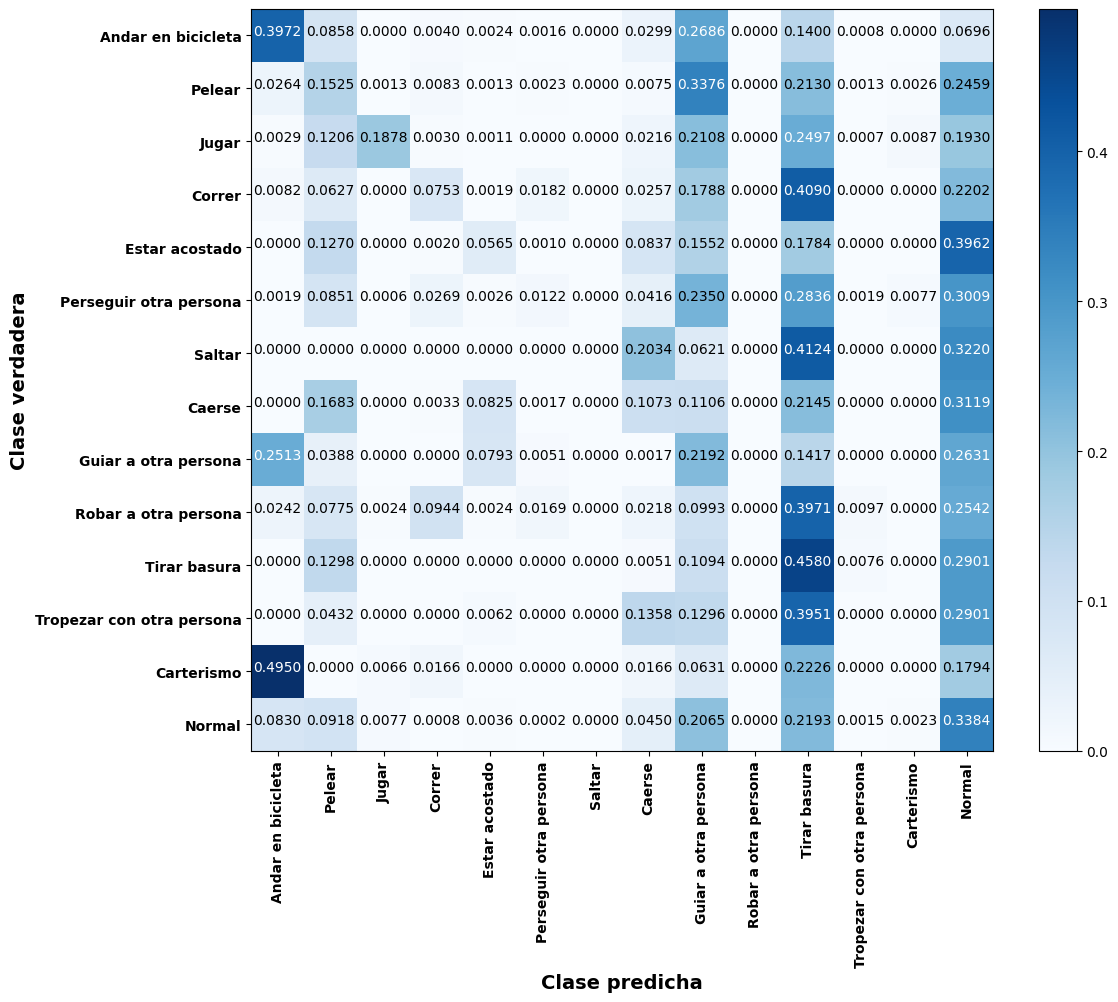

In [40]:
plt.figure(figsize=(12, 10))
cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)
plt.imshow(cm_sum, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
plt.colorbar()
# Replace class names with the ones from the replace list
replace = [
    "Andar en bicicleta",
    "Pelear",
    "Jugar",
    "Correr",
    'Estar acostado',
    "Perseguir otra persona",
    "Saltar",
    "Caerse",
    "Guiar a otra persona",
    "Robar a otra persona",
    "Tirar basura",
    "Tropezar con otra persona",
    "Carterismo",
    'Normal',
]
updated_classes = replace
tick_marks = np.arange(num_classes)   
plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
thresh = cm_sum.max() / 2.0
for i, j in np.ndindex(cm_sum.shape):
    plt.text(j, i, f"{cm_sum[i, j]:.4f}",
                        horizontalalignment="center",
                        color="white" if cm_sum[i, j] > thresh else "black")   
plt.tight_layout()
#plt.savefig(f"CM/confusion_matrix_{mode_names[mode]}.png", bbox_inches='tight')
plt.show()

In [41]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

        Name                                              Event Mode  TP  FP  \
0    4_110_1                        a video of a person running    0  16   2   
1    2_083_1  a video of a person aggressively chasing anoth...    0   0   0   
2         20  a video of a person deliberately throwing garb...    0  26  14   
3    3_095_1  a video of a person deliberately throwing garb...    0  19  19   
4    4_107_1  a video of a person aggressively chasing anoth...    0   0   0   
..       ...                                                ...  ...  ..  ..   
247  4_109_1  a video of a group of people playing a sport t...    0   0   0   
248  4_105_1  a video of multiple people engaged in a physic...    0   0   0   
249  4_082_1  a video of multiple people engaged in a physic...    0  19   0   
250   000259                        a video of a person running    0   0   0   
251  1_088_1  a video of multiple people engaged in a physic...    0   0   1   

      FN   TN  
0     13   33  
1    14

/tmp/ipykernel_284335/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.9302120141342756 0.5 1.0 0.42452830188679247 0.9027777777777778
 0.9180327868852459 0.0 0.9979674796747967 0.96 0.7531969309462916]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_284335/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.1878344630752765 0.10726072607260725 0.012163892445582587
 0.4580152671755725 0.21922428330522767 0.0 0.056451612903225805 0.0
 0.39724919093851135 0.07528230865746549 0.0 0.0 0.15247217188713436]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_recall, "Recall"] = (
/tmp/ipykernel_284335/2034563803.py:25: FutureWarning: Setting an 

In [42]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check = df_check.copy()
for column in df_check.select_dtypes(include=['category']).columns:
    df_check[column] = df_check[column].astype(str)
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values2 = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values2)

                     AP
Mode                   
CLIP y Reglas  0.315837


/tmp/ipykernel_284335/4034585013.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8888888888888888 0.65 0.5 0.6666666666666666 0.4230769230769231 1.0
 0.8387096774193549 1.0 0.2318840579710145 0.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0
 1.0 1.0 1.0 0.7857142857142857 1.0 1.0 0.09523809523809523 1.0 1.0 0.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8333333333333334 1.0 1.0 1.0
 0.7142857142857143 1.0 1.0 1.0 1.0 0.8 0.0 0.6666666666666666
 0.3333333333333333 0.6538461538461539 1.0 0.9831932773109243 1.0 1.0
 0.6862745098039216 0.5 0.9722222222222222 1.0 0.9818181818181818 0.0
 0.9411764705882353 1.0 1.0 1.0 0.9473684210526315 0.8727272727272727 1.0
 0.0 1.0 0.4444444444444444 0.3181818181818182 1.0 1.0 1.0 1.0
 0.3225806451612903 0.8 1.0 0.16666666666666666 1.0 0.36 1.0
 0.7658227848101266 1.0 0.7096774193548387 0.898989898989899 0.6875
 0.4772727272727273 1.0 1.0 0.75 1.0 1.0 1.0 1.0 1.0 1.0 0.0
 0.17721518

In [43]:
df_chad=df.loc[df["Name"].str.contains("_1")]
print(df_chad)


        Name                                              Event Mode  TP  FP  \
0    4_110_1                        a video of a person running    0  16   2   
1    2_083_1  a video of a person aggressively chasing anoth...    0   0   0   
3    3_095_1  a video of a person deliberately throwing garb...    0  19  19   
4    4_107_1  a video of a person aggressively chasing anoth...    0   0   0   
5    3_084_1  a video of a person deliberately throwing garb...    0   8   4   
..       ...                                                ...  ...  ..  ..   
243  3_087_1                        a video of a person running    0   8   0   
247  4_109_1  a video of a group of people playing a sport t...    0   0   0   
248  4_105_1  a video of multiple people engaged in a physic...    0   0   0   
249  4_082_1  a video of multiple people engaged in a physic...    0  19   0   
251  1_088_1  a video of multiple people engaged in a physic...    0   0   1   

      FN   TN  
0     13   33  
1    14